# 線形回帰モデル

In [1]:
!date

2019年 8月25日 日曜日 10時54分20秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats, special

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Data

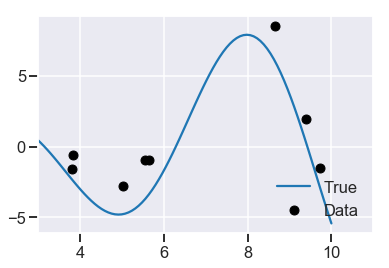

In [3]:
lb = 2
ub = 10
N = 10

x = np.linspace(lb, ub, 100)
y = np.sin(x) * x

x_data = (ub - lb) * np.random.random(N) + lb
y_data = x_data * np.sin(x_data) + np.random.random(N) * 3.

plt.plot(x, y, label='True')
plt.plot(x_data, y_data, 'ok', label='Data')
plt.xlim([lb + 1, ub + 1])
plt.legend(loc='lower right')
plt.show()

# Model

In [4]:
class LinearRegression:
    def __init__(self, lmd=10.0, m_w=[0, 0], lmd_w=[[1, 0], [0, 1]]):
        
        if not (len(m_w) == len(lmd_w)):
            raise 'Dim error'
            
        self.lmd = lmd
        self.m_w = np.array(m_w)
        self.lmd_w = np.array(lmd_w)
        self.d = len(m_w)
        
        self.m_w_prior = self.m_w
        self.lmd_w_prior = self.lmd_w
        
        # Sample for w
        self.w = None
    
    def inference(self, x, y):
        # Convert x to features
        x = self.basis_fn(x)
        
        lmd_w = self.lmd_w
        self.lmd_w += self.lmd * np.dot(x.T, x)
        self.m_w = np.dot(
            np.linalg.inv(self.lmd_w),
            (self.lmd * np.sum(y[:, None] * x, axis=0)
             + np.dot(lmd_w, self.m_w)))

    def predict(self, x):
        """
        Predict y for given x.
        Return parameters for predictive distribution.
        """
        x = self.basis_fn(x)
        
        # Update parameters
        mu = np.sum(self.m_w * x, axis=1)
        lmd = (self.lmd ** -1
               + np.dot(np.dot(x, np.linalg.inv(self.lmd_w)), x.T)) ** -1

        return mu, np.diag(lmd) ** -0.5
    
    def sample_fn(self, x):
        """
        Sample function.
        """
        x = self.basis_fn(x)
        self.w = np.random.multivariate_normal(
            self.m_w, np.linalg.inv(self.lmd_w))
        return np.sum(self.w * x, axis=1)
    
    def sample_data(self, x):
        """
        Sample data from sampled function.
        """
        x = self.basis_fn(x)
        
        if self.w is None:
            self.sample_fn(x)
        data = (np.random.randn(x.shape[0]) * self.lmd ** -1
                + np.sum(self.w * x, axis=1))
        return data
    
    def basis_fn(self, x):
        """
        return phi(x) = [1, x, x^2, ..., x^d-1]
        """
        return np.array([x ** i for i in range(self.d)]).T
    
    def evidence(self, x):
        """
        return ln p(Y|X)        
        """
        y, _ = self.predict(x)
        N = len(y)
        lkh = -0.5 * (self.lmd * np.sum(y ** 2) 
                      - N * np.log(self.lmd)
                      + N * np.log(2 * np.pi)
                      + np.dot(np.dot(self.m_w_prior, self.lmd_w_prior),
                               self.m_w_prior)
                      - np.log(np.linalg.det(self.lmd_w_prior))
                      - np.dot(np.dot(self.m_w, self.lmd_w), self.m_w)
                      + np.log(np.linalg.det(self.lmd_w)))
        
        return lkh

## 学習前の状態で重みパラメータをサンプルした例

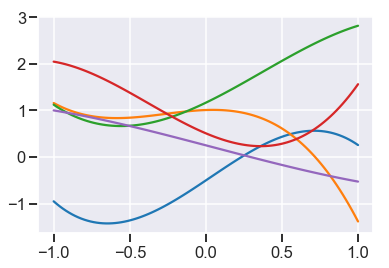

In [5]:
x = np.linspace(-1., 1., 100)
lr = LinearRegression(lmd=10.0, m_w=np.zeros(4), lmd_w=np.eye(4))

plt.figure()
for _ in range(5):
    y = lr.sample_fn(x)
    plt.plot(x, y)
plt.show()

## 適当にサンプルした関数からデータをサンプルする

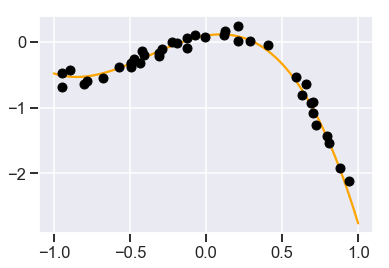

In [6]:
lr = LinearRegression(lmd=10.0, m_w=np.zeros(4), lmd_w=np.eye(4))

x_gen = 2 * np.random.rand(40) - 1
y_pred = lr.sample_fn(x)
y_gen = lr.sample_data(x_gen)

plt.figure()
plt.plot(x, y_pred, color='orange', label='Prediction')
plt.plot(x_gen, y_gen, 'ok')
plt.show()

## データから推論

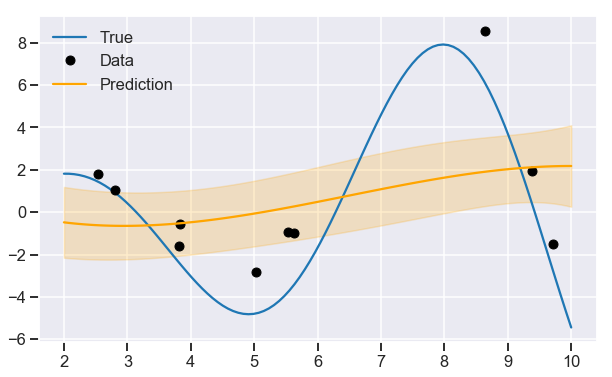

In [7]:
lr = LinearRegression(lmd=2.0, m_w=np.zeros(4), lmd_w=np.eye(4))
lr.inference(x_data, y_data)

x = np.linspace(lb, ub, 100)
y_pred, y_std = lr.predict(x)
y = np.sin(x) * x

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='True')
plt.plot(x_data, y_data, 'ok', label='Data')
plt.plot(x, y_pred, color='orange', label='Prediction')
plt.fill_between(x, y_pred - 2 * y_std, y_pred + 2 * y_std,
                 color='orange', alpha=0.2)
plt.legend()
plt.show()

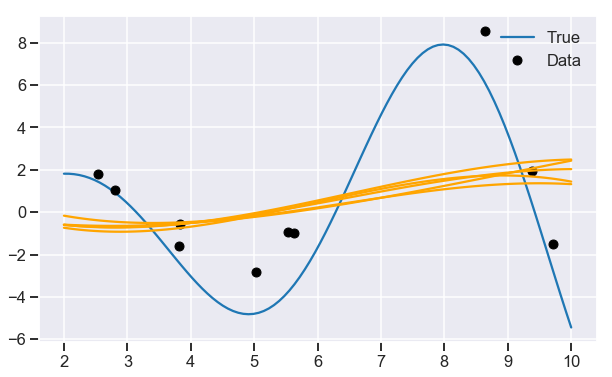

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='True')
plt.plot(x_data, y_data, 'ok', label='Data')

for _ in range(5):
    y_pred = lr.sample_fn(x)
    plt.plot(x, y_pred, color='orange')
plt.legend()
plt.show()

## 次元の異なる基底関数を用いる．

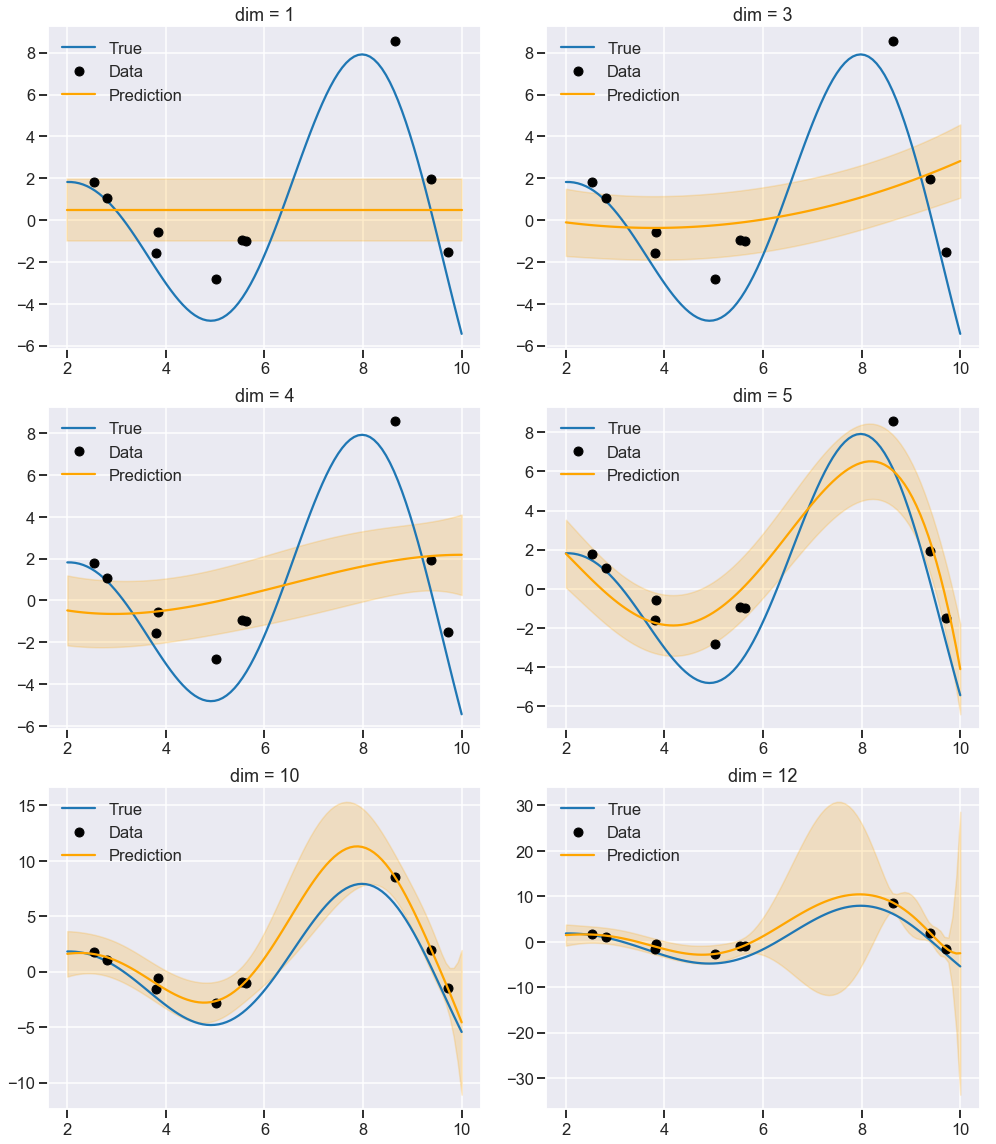

In [9]:
plt.figure(figsize=(14, 16))

for i, d in enumerate([1, 3, 4, 5, 10, 12]):
    lr = LinearRegression(lmd=2.0, m_w=np.zeros(d), lmd_w=np.eye(d))
    lr.inference(x_data, y_data)

    x = np.linspace(lb, ub, 100)
    y_pred, y_std = lr.predict(x)
    y = np.sin(x) * x

    plt.subplot(3, 2, i + 1)
    plt.plot(x, y, label='True')
    plt.plot(x_data, y_data, 'ok', label='Data')
    plt.plot(x, y_pred, color='orange', label='Prediction')
    plt.fill_between(x, y_pred - 2 * y_std, y_pred + 2 * y_std,
                     color='orange', alpha=0.2)
    plt.title(f'dim = {d}')
    plt.legend(loc='upper left')
    
plt.tight_layout()
plt.show()

## 周辺尤度でモデル選択

In [10]:
D = 12
lkh_list = np.zeros(D - 1)
for i, d in enumerate(range(1, D)):
    lr = LinearRegression(lmd=2.0, m_w=np.zeros(d), lmd_w=np.eye(d))
    lr.inference(x_data, y_data)

    x = np.linspace(lb, ub, 100)
    lkh_list[i] = lr.evidence(x_data)

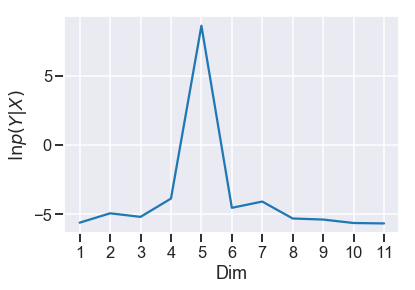

In [11]:
plt.figure()
plt.plot(np.arange(1, D), lkh_list)
plt.xticks(np.arange(1, D))
plt.xlabel('Dim')
plt.ylabel(r'$\ln p(Y|X)$')
plt.show()